# Compare VAE & GSVAE

In [21]:
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt


In [22]:
# Load pallets library from project root
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from pallets import (
    images as I,
    datasets as DS,
    models as M,
    logging as L,
    paths as P
)


# Settings

In [23]:
USE_GPU = True
LOG_LEVEL = 'INFO'
LABELS_FILE = 'pallets_labels.json'

TEST_SIZE = 1000
EPOCHS = 500
LR = 1e-03
BATCH_SIZE = 32

In [24]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=USE_GPU)

# Logging
L.init_logger(level=LOG_LEVEL, notebook=True)


INFO | gpu: cuda


<Logger pallets (INFO)>

# Helpers

In [25]:
import json
import random


pallets_labels_file = os.path.join(P.ARTIFACTS_DIR, 'pallets_labels.json')
raw_labels = json.load(open(pallets_labels_file))
label_keys = [k for k in raw_labels["0"].keys()]


# Convert labels to same format as dataset
# (this code is in pallets.datasets.base.CPunksData)
ds_labels = []
for _, label in raw_labels.items():
    t = torch.tensor([v for _, v in label.items()])
    ds_labels.append(t)

print(f"Labels: {len(ds_labels)}")


Labels: 10000


In [26]:
def rand_label():
    label_idx = int(random.random() * len(ds_labels))
    features = ds_labels[label_idx]
    enabled_names = [k for k,v in zip(label_keys, features) if v.item() == 1]
    return features, enabled_names


features, enabled_names = rand_label()

print(f"Example: {enabled_names}\n")
print(features)

Example: ['male', 'clownHairGreen', 'smallShades', 'mole', 'cigarette', 'earring']

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1])


In [27]:
latent_dims = 32  # Both models have this
all_colors = I.get_punk_colors()
mapper = DS.ColorOneHotMapper(all_colors)

classes_dim = len(label_keys)

## The Models

### Regular Labeled VAE

In [28]:
VAE_FILE = 'vae'

model_vae, _, _ = M.load(VAE_FILE, device)
model_vae = model_vae.to(device)

INFO | model blob loaded from /home/jmsdnns/ML/pallets/saved/vae.pkl
INFO | training losses loaded from /home/jmsdnns/ML/pallets/saved/vae.pkl


### Gumbel VAE

In [29]:

GUMBEL_FILE = 'gsvae'

model_gumbel, _, _ = M.load(GUMBEL_FILE, device)
model_gumbel = model_gumbel.to(device)

INFO | model blob loaded from /home/jmsdnns/ML/pallets/saved/gsvae.pkl
INFO | training losses loaded from /home/jmsdnns/ML/pallets/saved/gsvae.pkl


## Comparisons

### Random Data

In [34]:
def show_two_heads(head_1, head_2):
    # Two pics, side by side
    page_size = 2
    view_x, view_y = 4*page_size, 4*page_size
    fig = plt.figure(figsize=(view_x, view_y))
    fig.add_subplot(2, 2, 1)
    plt.imshow(to_pil_image(head_1))
    plt.axis('off')
    fig.add_subplot(2, 2, 2)
    plt.imshow(to_pil_image(head_2))
    plt.axis('off')

    plt.show()

In [35]:
def image_duel(m1, m2):
    # shape of x1 is latent dims
    x1 = torch.randn(1, latent_dims).to(device)
    print("VAE: ", x1.shape)
    with torch.no_grad():
        m1.eval()
        recon_x1 = m1.decode(x1)
    onehot_x1 = recon_x1[0].view(222, 24, 24)
    decoded_x1 = DS.one_hot_to_rgba(onehot_x1, mapper)

    # shape of x2 is diff from x1
    x2 = torch.randn(1, latent_dims * classes_dim).to(device)
    print("GUMBEL: ", x2.shape)
    with torch.no_grad():
        m2.eval()
        recon_x2 = m2.decoder(x2)
    print(recon_x2.shape)
    onehot_x2 = recon_x2[0].view(222, 24, 24)
    decoded_x2 = DS.one_hot_to_rgba(onehot_x2, mapper)

    show_two_heads(decoded_x1, decoded_x2)


VAE:  torch.Size([1, 32])
GUMBEL:  torch.Size([1, 2944])
torch.Size([1, 127872])


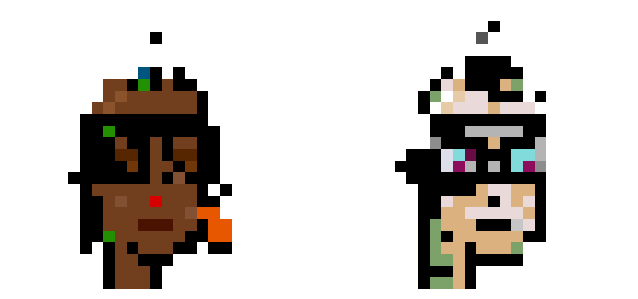

VAE:  torch.Size([1, 32])
GUMBEL:  torch.Size([1, 2944])
torch.Size([1, 127872])


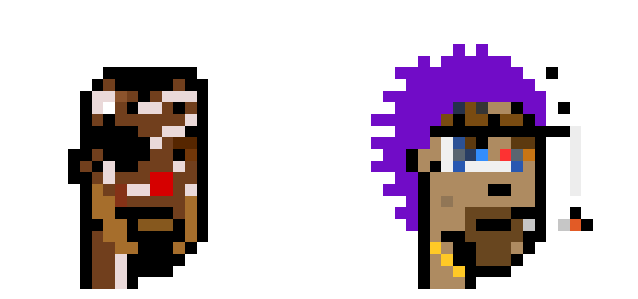

VAE:  torch.Size([1, 32])
GUMBEL:  torch.Size([1, 2944])
torch.Size([1, 127872])


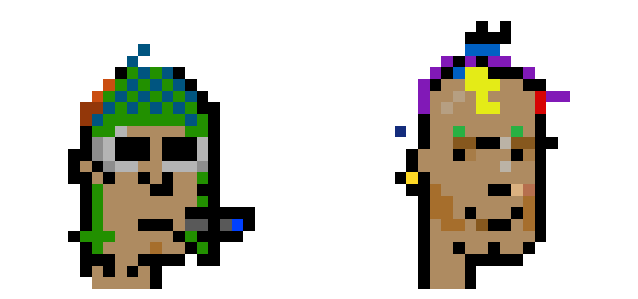

VAE:  torch.Size([1, 32])
GUMBEL:  torch.Size([1, 2944])
torch.Size([1, 127872])


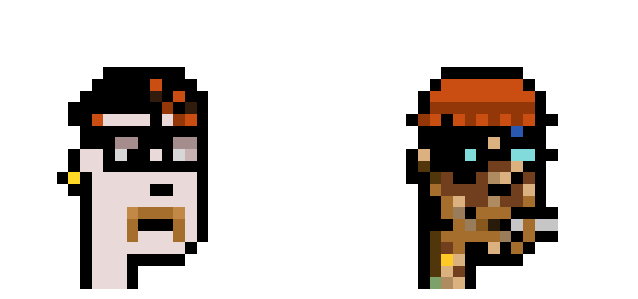

VAE:  torch.Size([1, 32])
GUMBEL:  torch.Size([1, 2944])
torch.Size([1, 127872])


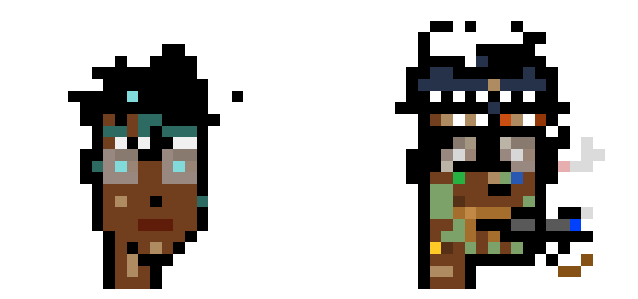

VAE:  torch.Size([1, 32])
GUMBEL:  torch.Size([1, 2944])
torch.Size([1, 127872])


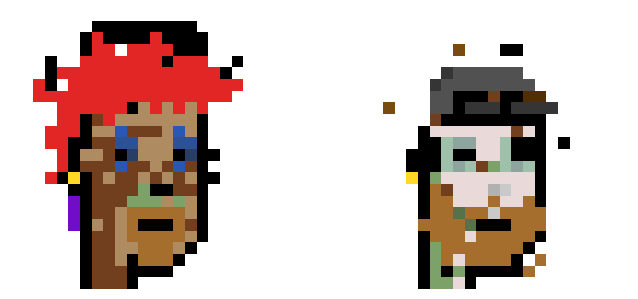

VAE:  torch.Size([1, 32])
GUMBEL:  torch.Size([1, 2944])
torch.Size([1, 127872])


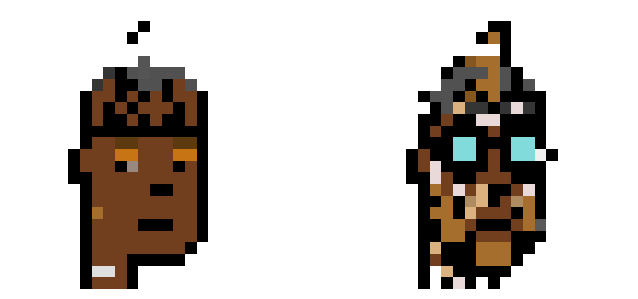

VAE:  torch.Size([1, 32])
GUMBEL:  torch.Size([1, 2944])
torch.Size([1, 127872])


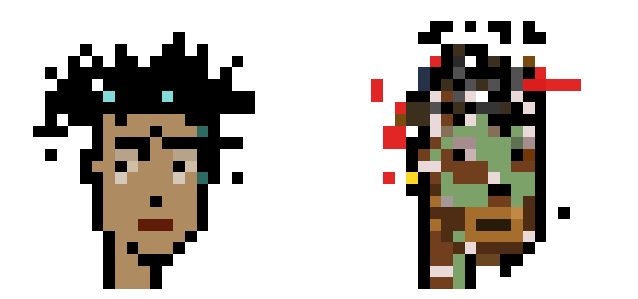

VAE:  torch.Size([1, 32])
GUMBEL:  torch.Size([1, 2944])
torch.Size([1, 127872])


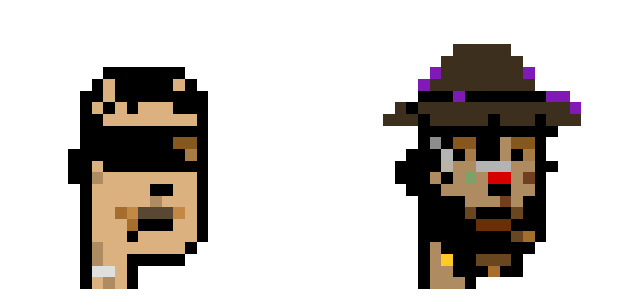

VAE:  torch.Size([1, 32])
GUMBEL:  torch.Size([1, 2944])
torch.Size([1, 127872])


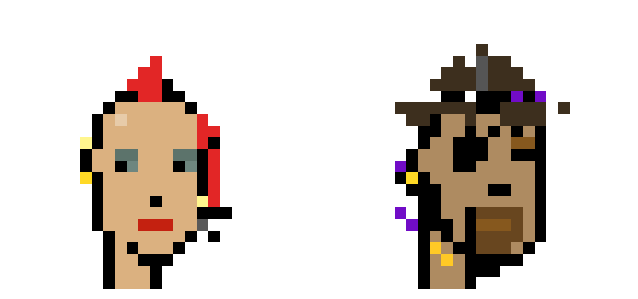

In [36]:
image_duel(model_vae, model_gumbel)
image_duel(model_vae, model_gumbel)
image_duel(model_vae, model_gumbel)
image_duel(model_vae, model_gumbel)
image_duel(model_vae, model_gumbel)
image_duel(model_vae, model_gumbel)
image_duel(model_vae, model_gumbel)
image_duel(model_vae, model_gumbel)
image_duel(model_vae, model_gumbel)
image_duel(model_vae, model_gumbel)